# Behavioral Cloning Model

Inspired by comma ai's model https://github.com/commaai/research/blob/master/train_steering_model.py

Udacity's open source simulator was used to train and test this model, the simulator can be found here - https://github.com/udacity/self-driving-car-sim

Anurag Tiwari (tiwari.anurag50@gmail.com)

## Load Data

Load the Simulated data, instead of driving the car of simulator myself, I have used sample data provided by Udacity.

In [1]:
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os

path = "/home/anurag/carnd/CarND-Behavioral-Cloning-P3/data/"
data = []
test_data = []

with open(path+'driving_log_all.csv') as f:
    csvreader = csv.reader(f)
    for v in csvreader:
        data.append(v)
    del csvreader

with open(path+'driving_log_validation.csv') as f:
    csvreader = csv.reader(f)
    for v in csvreader:
        test_data.append(v) 
    del csvreader
        
print("data imported")
print("data size:", len(data))
print("test data size:", len(test_data))

data imported
data size: 8036
test data size: 1036


## Visualize Data

View a sample from the dataset. Crop a smaple image and visualize how it looks to the car while driving.

(160, 320, 3)
(75, 320, 3)


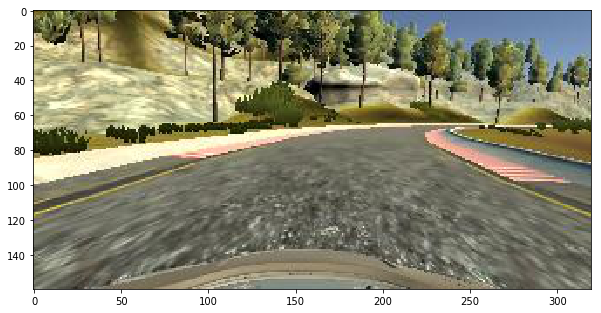

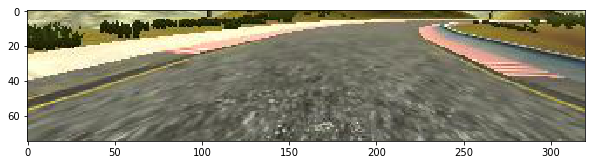

In [2]:
image = plt.imread(path+data[6000][0].strip())
print(image.shape)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.figure(figsize=(10,10))
image = image[60:135,:,:]
plt.imshow(image)
plt.figure(figsize=(10,10))
print(image.shape)

## Import Data

Crop all the images from the dataset and import images and corresponding steering angles into seperate arrays. 

Also, the original data was split 80/20 randomly to test the trained model, the test data is loaded here as well. 

Finally, images from left and right cameras are loaded along with respective steering angles. A small correction is applied the steering angles for left and right images. 

The images are also flipped horizontally to augment data and to even out the distributions between left and right turns. Since the training data consists of a large number of frames with zero angle (driving straight) those frames are excluded while augmenting the data so that the model is trained evenly for driving staight as well as for driving while turning. 

(35133, 75, 320, 3)
(3108, 75, 320, 3)


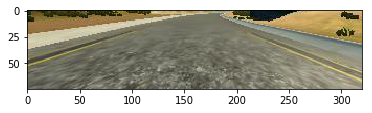

In [3]:
import numpy as np

X, X_test = [], []
y, y_test = [], []

#Read center-image, left-image, right-image, steering angle line by line from data:
for v in data:
    images = []
    for i in range(3):
        image_read = cv2.imread(path+v[i].strip())
        images.append(image_read[60:135,:,:])  
    X += images
    steering = float(v[3])
    y += [steering, steering+0.35, steering-0.35] 
    
    #Flip the images and change the direction of steering to augment data
    if abs(steering) == 0: continue
    for i in range(3):
        images[i] = cv2.flip(images[i], 1)
    X += images
    y += [-1*steering, -1*steering-0.35,  -1*steering+0.35]
    
for v in test_data:
    images = []
    for i in range(3):
        image_read = cv2.imread(path+v[i].strip())
        images.append(image_read[60:135,:,:])  
    X_test += images
    steering = float(v[3])
    y_test += [steering, steering+0.35, steering-0.35] 
    
X = np.array(X)
y = np.array(y)
X_test = np.array(X_test)
y_test = np.array(y_test)
print (X.shape)
print (X_test.shape)
plt.imshow(X[0][...,::-1]) #convert BGR to RGB

## Training Data Generator
 
In some models, loading the entire dataset can cause GPU to go out of memory. In order to avoid that, the generator below creates batches of data for the model to consume. The batch size is assigned by the model.

In [4]:
def train_data_generator(batch_size, X, y):

    batches_per_epoch = len(X) // batch_size

    i = 0
    while(True):
        X_batch, y_batch = [], []
        start = i * batch_size
        end   = start + batch_size

        X_batch = X[start:end]
        y_batch = y[start:end]
        i += 1
        
        if i == batches_per_epoch - 1:
            i = 0
            
        yield X_batch, y_batch

## Model



In [5]:
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Flatten, Dropout, Lambda#, Activation,
from keras.layers.convolutional import Conv2D
from keras.layers.advanced_activations import ELU
from keras.regularizers import l2
from keras import regularizers
from keras.optimizers import Adam
from keras import backend as K

input_shape = X[0].shape 

model = Sequential()

model.add(Lambda(lambda x: x/127.5-1.0,input_shape=input_shape))

# Convolution layers
model.add(Conv2D(filters=16, kernel_size=(8, 8), strides=(4, 4), padding='valid'))
model.add(ELU())
model.add(Dropout(0.10))
model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(2, 2), padding='valid'))
model.add(ELU())
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='valid'))
model.add(ELU())
model.add(Flatten())

# Fully connected layers
model.add(Dense(100))
model.add(ELU())
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(ELU())
model.add(Dropout(0.25))
model.add(Dense(1))

print(model.summary())

model.compile(optimizer=Adam(lr=1e-4), loss='mse')

history = model.fit_generator(train_data_generator(10, X, y), steps_per_epoch=3514, 
                              epochs=3, verbose=1)

loss = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', loss)

model.save_weights('./model.h5')
json_string = model.to_json()
with open('./model.json', 'w') as f:
    f.write(json_string)
    
print("model saved")
    
K.clear_session()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 75, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 79, 16)        3088      
_________________________________________________________________
elu_1 (ELU)                  (None, 17, 79, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 79, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 38, 32)         12832     
_________________________________________________________________
elu_2 (ELU)                  (None, 7, 38, 32)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 38, 32)         0         
__________